# Experiments

In this notebook is implemented the three experiments described in the paper: "Vector Symbolic Architectures for Semantic Features Representations". Submited to *IEEE Transactions on Cognitive and Developmental Systems*

## Header

Libraries and additional programs

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import random
from scipy.stats.stats import pearsonr

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]

pathh = '../Data/' 
exp_file = '../Data/ExperimentalResults.xlsx'   

## Initializing memory and encoding dataset in HD space

In [2]:
%run EncodingDataset.ipynb
Init_mem()

End of memory initialization
Begining to encode dataset...
End of encoding


## Experiment 1

Given a concept it retrieves the "num_concepts" most similar concepts to it (for each different method). A comparison between methods is done by counting the number of coincidences between lists of concepts.

(This experiment takes a while...)

In [3]:
# List of all concepts in dataset
Concepts = get_concepts_list() 

# Test concepts
sample_size = 10
#Test_Concepts = random.sample(Concepts, sample_size)
Test_Concepts =  ['spoon'] #, 'airplane', chair']
#print Test_Concepts

num_concepts = 11
coincidence = []

for test_concept in Test_Concepts:
    print "\n\nConcept: ", test_concept
    # Asking closest concept of another concept's definition...
    HDC_sim = HDvector.getLabelSP(Dict[test_concept].getPointer())[:num_concepts]
    HDC_sim = NormalizeHammDist(HDC_sim)
    print "HDC_sim: ", HDC_sim
    
    DatSet_sim = ClosestConcepts(test_concept, num_concepts)
    print "DatSet_sim: ", DatSet_sim

    concept = wn.synset( get_synset(test_concept) )
    # Path similarity
    LC_sim = apply_sim_metric(wn.lch_similarity, num_concepts, concept ) 
    print "LC_sim: ", LC_sim
    WUP_sim = apply_sim_metric(wn.wup_similarity, num_concepts, concept )
    print "WUP_sim: ", WUP_sim
    
    # Information Content
    Res_sim = apply_sim_metric(wn.res_similarity, num_concepts, concept, brown_ic)
    print "Res_sim: ", Res_sim
    JC_sim = apply_sim_metric(wn.jcn_similarity, num_concepts, concept, brown_ic)
    print "JC_sim: ", JC_sim
    
    # Comparing lists agains HDC_sim for counting coincidence.
    # Creating name sets
    HDC_names = set([x[0] for x in HDC_sim])
    DatSet_names = set([x[0] for x in DatSet_sim])
    LC_names = set([x[0] for x in LC_sim])
    WUP_names = set([x[0] for x in WUP_sim])
    Res_names = set([x[0] for x in Res_sim])
    JC_names = set([x[0] for x in JC_sim])
    
    coincidence = coincidence + [[len(HDC_names.intersection(DatSet_names)), 
                                 len(HDC_names.intersection(LC_names)), 
                                 len(HDC_names.intersection(WUP_names)),    
                                 len(HDC_names.intersection(Res_names)), 
                                 len(HDC_names.intersection(JC_names))]]
    print coincidence

coincidence = np.array(coincidence)

# Measuring average against each method.
print "Average: ", np.mean(coincidence, axis = 0)



Concept:  spoon
HDC_sim:  [['spoon', 1.0], ['ladle', 0.677], ['spatula', 0.633], ['colander', 0.624], ['fork', 0.613], ['tongs', 0.604], ['pot', 0.598], ['strainer', 0.585], ['bucket', 0.583], ['grater', 0.582], ['peg', 0.582]]
DatSet_sim:  [['spoon', 1.0], ['fork', 0.546], ['ladle', 0.411], ['spatula', 0.395], ['tongs', 0.35], ['colander', 0.336], ['bowl', 0.292], ['strainer', 0.282], ['dish', 0.282], ['peg', 0.28], ['grater', 0.259]]
LC_sim:  [['spoon', 3.638], ['bag', 2.539], ['basket', 2.539], ['bin_(waste)', 2.539], ['box', 2.539], ['cup', 2.539], ['dish', 2.539], ['envelope', 2.539], ['fork', 2.539], ['thimble', 2.539], ['ashtray', 2.251]]
WUP_sim:  [['fork', 0.9], ['spoon', 0.9], ['bag', 0.875], ['basket', 0.875], ['bin_(waste)', 0.875], ['box', 0.875], ['envelope', 0.875], ['thimble', 0.875], ['ashtray', 0.824], ['barrel', 0.824], ['bathtub', 0.824]]
Res_sim:  [['spoon', 11.208], ['fork', 10.574], ['cup', 7.49], ['dish', 7.49], ['plate', 7.49], ['saucer', 7.49], ['ambulance',

## Experiment 2

### a) Human-judged similarity

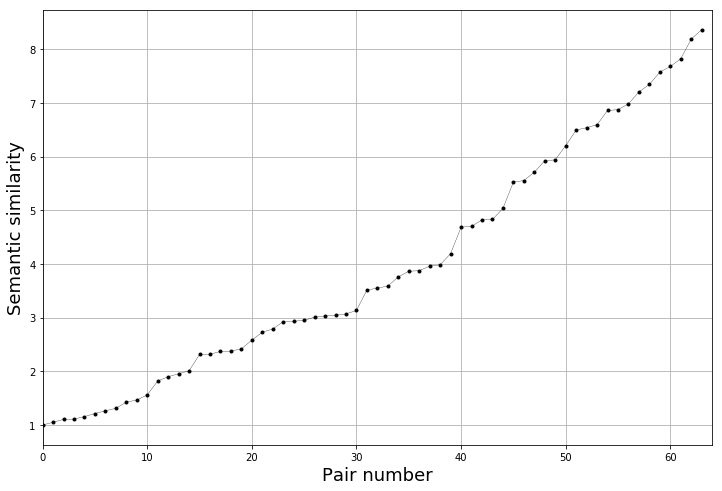

In [4]:
def ListofPairs (number):
    "It obtains the list of concept pairs rated by Humans"
    df = pd.read_excel(exp_file)
    if number > 0:
        string = 'Q' + str(number)    
    else:
        string = 'average'
    # 1) List of concepts
    ordered = df.sort_values(by=string)
    c1 = map(str, list( ordered['concept 1'] ))
    c2 = map(str, list( ordered['concept 2'] ))
    L1 = map(list, zip(c1,c2))

    # 2) Human similarity and stdev
    ordered = df.sort_values(by=string)
    L2 = list(ordered[string])
    L3 = list(ordered['stdev'])
    return L1, L2, L3

PConcepts, Hum_Sim, stdev = ListofPairs(0)

x = np.array(range(64))
stdev = np.array(map(lambda x: x*0.25, stdev))

plt.rcParams["figure.figsize"] = [12,8]

#plt.plot(Hum_Sim, fmt="k-")
plt.plot(Hum_Sim, color='k', linestyle='-', marker='.', markersize=6, linewidth=.3 )  


plt.xlim((0,64))
plt.xlabel('Pair number', fontsize=18)
plt.ylabel('Semantic similarity', fontsize=18)
plt.grid(True)
plt.savefig('HumSim.png', dpi=300)


### b) Measuring similarity

In this cell we measure the similarity of each pair of concepts with each similarity measure.

In [5]:
# Create dictionary of distances for each method
Dict_HD = {}; Dict_McRae = {}; Dict_wup = {}; Dict_lch = {}; Dict_res = {}; Dict_jcn = {}

# Loop over all pairs of concepts
key = 0
print "Starting"
for pair in PConcepts:
    print key,
    Dict_HD[key] = 1. - HDvector.dist(Dict[pair[0]].getPointer(), Dict[pair[1]].getPointer()) / float(N)
    Dict_McRae[key] = McRae_simi(pair)
    Dict_wup[key] = similarity_fun(wn.wup_similarity, pair)
    Dict_lch[key] = similarity_fun(wn.lch_similarity, pair)
    Dict_res[key] = similarity_fun(wn.res_similarity, pair, brown_ic)
    Dict_jcn[key] = similarity_fun(wn.jcn_similarity, pair, brown_ic)
    key += 1
print "End"

Starting
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 End


### c) Computing correlations

In [6]:
# 1) Obtain "human list", it can be the average responses or an specific one
Hum_sim =  ListofPairs(1) #or Q + #0-30
    
# 2) Obtain list of ordered concepts (keys)
keys = map(lambda x: PConcepts.index(x), Hum_sim[0])
    
# 3) Create a list of distances according to each metric by consulting the appropiate dictionary
HD_sim = [Dict_HD[x] for x in keys]
McRae_sim = [Dict_McRae[x] for x in keys]
wup_sim = [Dict_wup[x] for x in keys]
lch_sim = [Dict_lch[x] for x in keys]
res_sim = [Dict_res[x] for x in keys]
jcn_sim = [Dict_jcn[x] for x in keys]

# 4) Calculate correlations
correlations = [['HDC', pearsonr(Hum_sim[1], HD_sim)[0]], ['McRae', pearsonr(Hum_sim[1], McRae_sim)[0]],
                ['wup', pearsonr(Hum_sim[1], wup_sim)[0]], ['lch', pearsonr(Hum_sim[1], lch_sim)[0]],
                ['res', pearsonr(Hum_sim[1], res_sim)[0]], ['jcn', pearsonr(Hum_sim[1], jcn_sim)[0]]]

print correlations

[['HDC', 0.712688032346265], ['McRae', 0.6579291336168837], ['wup', 0.5024104680950027], ['lch', 0.5237371792119226], ['res', 0.6407738417122745], ['jcn', 0.6132415801404195]]


## d) Plotting

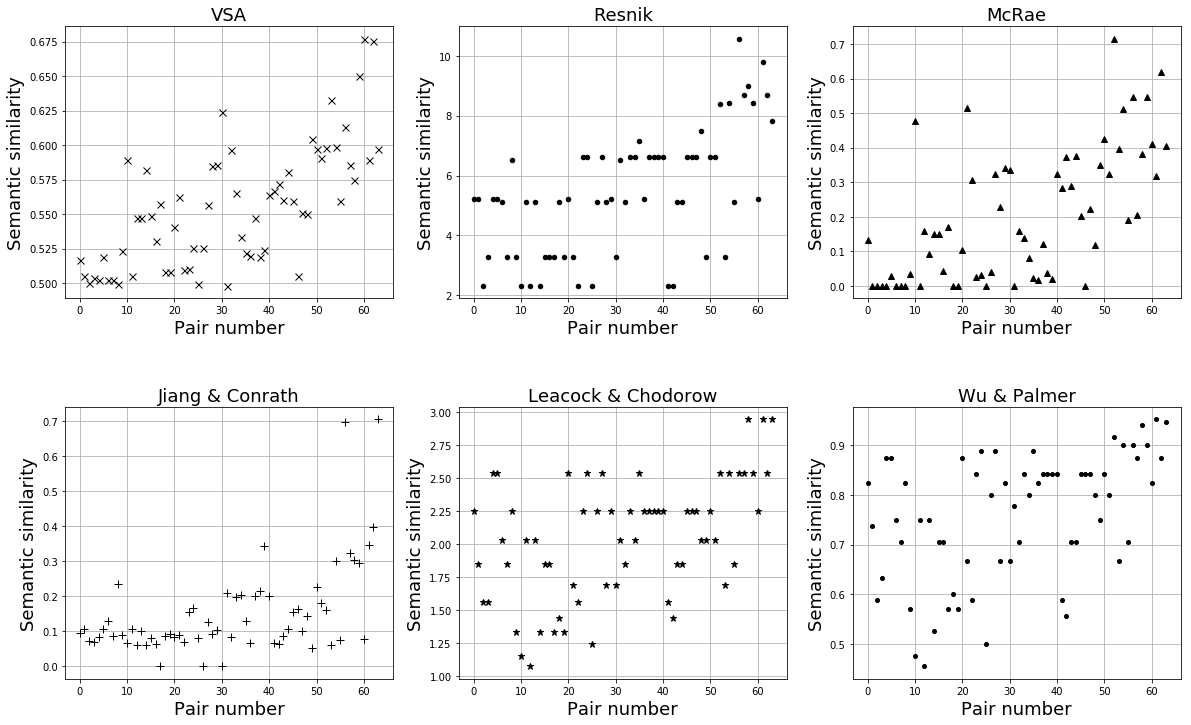

In [7]:
# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18

plt.subplots_adjust(hspace=0.4)
plt.subplot(231)
plt.plot(HD_sim, color='k', linestyle='None', marker='x', markersize=7, linewidth=1 )  

plt.title('VSA', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(232)
plt.plot(res_sim, color='k', linestyle='None', marker='.', markersize=9, linewidth=1 )  
plt.title('Resnik', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(233)
plt.plot(McRae_sim, color='k', linestyle='None', marker='^', markersize=6, linewidth=1 )  
plt.title('McRae', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(234)
plt.plot(jcn_sim, color='k', linestyle='None', marker='+', markersize=8, linewidth=1 )  
plt.title('Jiang & Conrath', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(235)
plt.plot(lch_sim, color='k', linestyle='None', marker='*', markersize=7, linewidth=1 )  
plt.title('Leacock & Chodorow', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(236)
plt.plot(wup_sim, color='k', linestyle='None', marker='.', markersize=8, linewidth=1 )  
plt.title('Wu & Palmer', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)


plt.savefig('SubPlots.png') #, dpi=1000)